In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

#Africa Soil Prediction

##Source = www.kaggle.com Africa Soil Property Prediction Challenge

###Data munged and modified by Jarret Petrillo, GADs-14 TA

Predict physical and chemical properties of soil using spectral measurements

"Advances in rapid, low cost analysis of soil samples using infrared spectroscopy, georeferencing of soil samples, and greater availability of earth remote sensing data provide new opportunities for predicting soil functional properties at unsampled locations. Soil functional properties are those properties related to a soil’s capacity to support essential ecosystem services such as primary productivity, nutrient and water retention, and resistance to soil erosion. Digital mapping of soil functional properties, especially in data sparse regions such as Africa, is important for planning sustainable agricultural intensification and natural resources management."

"Diffuse reflectance infrared spectroscopy has shown potential in numerous studies to provide a highly repeatable, rapid and low cost measurement of many soil functional properties. The amount of light absorbed by a soil sample is measured, with minimal sample preparation, at hundreds of specific wavebands across a range of wavelengths to provide an infrared spectrum. The measurement can be typically performed in about 30 seconds, in contrast to conventional reference tests, which are slow and expensive and use chemicals."

"Conventional reference soil tests are calibrated to the infrared spectra on a subset of samples selected to span the diversity in soils in a given target geographical area. The calibration models are then used to predict the soil test values for the whole sample set. The predicted soil test values from georeferenced soil samples can in turn be calibrated to remote sensing covariates, which are recorded for every pixel at a fixed spatial resolution in an area, and the calibration model is then used to predict the soil test values for each pixel. The result is a digital map of the soil properties."

##pH is the target variable for predictions. 

####The data have been monotonously transformed from the original measurements and thus include negative values. 

   * PIDN: unique soil sample identifier
   * pH: pH values
   * ELEV: Shuttle Radar Topography Mission elevation data
   * Ref: average long-term Reflectance measurements from MODIS satellite images (Ref2 = red)
   * BSA: average long-term Black Sky Albedo measurements from MODIS satellite images (BSAN = near-infrared)
   * LST: average long-term Land Surface Temperatures from MODIS satellite images (LSTN = night time temperature)
   * Infrared01 - Infrared05: These are 5 bands of infrared absorbance measurements.

In [45]:
data = pd.read_csv("/Users/mrgh/GADS-22-NYC/Datasets/africa_ph.csv")

#Remove the "Unnamed: 0" column
del data['Unnamed: 0']

In [46]:
data.head()

,PIDN,pH,ELEV,REF2,BSAN,LSTN,Infrared01,Infrared02,Infrared03,Infrared04,Infrared05
0,d9u06tdU,-0.044436,0.904900,-0.352505,-0.710145,-0.371001,0.378298,0.056228,1.349732,1.81377,1.65483
1,qsQFu3ef,-0.455961,0.904900,-0.352505,-0.710145,-0.371001,0.374321,0.072229,1.459569,1.78552,1.62982
2,C4kj5IMN,-0.549490,0.971715,-0.352505,-0.702899,-0.399312,0.390773,0.048228,1.555917,1.73194,1.63317
3,p1SCgsM8,-0.951662,0.971715,-0.352505,-0.702899,-0.399312,0.385719,0.047679,1.662981,1.68115,1.69190
4,UqyLWYTl,-0.427903,0.929399,-0.506494,-0.695652,-0.543779,0.411471,0.043002,1.522019,1.71672,1.68936


In [47]:
#Remove the "PIDN" column - just for convenience
del data["PIDN"]

In [48]:
data.describe()

,pH,ELEV,REF2,BSAN,LSTN,Infrared01,Infrared02,Infrared03,Infrared04,Infrared05
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000
mean,0.019585,0.403813,-0.429374,-0.563376,-0.011037,0.307313,0.070904,1.315295,1.776879,1.494852
std,0.964509,1.607167,0.329725,0.209979,0.958168,0.092668,0.041800,0.253520,0.175960,0.159071
min,-1.886946,-1.326726,-1.642857,-1.007246,-2.720276,0.044781,0.009202,0.367167,1.295110,1.132220
25%,-0.717841,-1.050557,-0.657699,-0.695652,-0.448294,0.249050,0.041492,1.166361,1.675233,1.382195
50%,-0.137964,-0.166370,-0.442486,-0.586957,0.089564,0.294500,0.059636,1.340995,1.742140,1.506285
75%,0.455941,1.365367,-0.205937,-0.449275,0.750153,0.356444,0.090415,1.493126,1.848032,1.609793
max,2.480832,4.891537,0.335807,0.217391,1.519218,0.761519,0.246435,1.888528,2.569190,1.999830


##Aim: To predict pH using one, some or all of the other data features available

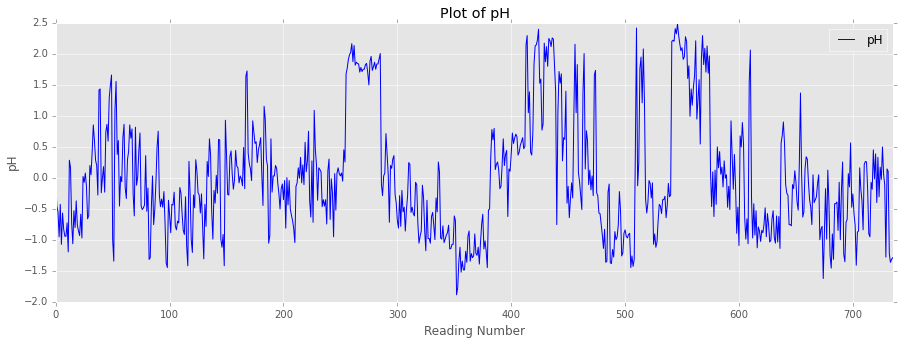

In [49]:
#What can be nice about using the Pandas plot functionality is that the index is used by default as the x value
mpl.style.use('ggplot')
ax = data[["pH"]].plot(figsize=(15,5), color='blue')
ax.set_ylabel("pH")
ax.set_xlabel("Reading Number")
ax.set_title("Plot of pH")

##Using corrwith list out the features and their correlation coefficients (against the pH)

In [50]:
data.corrwith(data["pH"])

pH            1.000000
ELEV          0.176186
REF2         -0.300895
BSAN          0.299121
LSTN         -0.219313
Infrared01    0.105399
Infrared02    0.556729
Infrared03   -0.080019
Infrared04   -0.267116
Infrared05    0.054529
dtype: float64

##Order the coefficients in terms of descending magnitude of correlation with pH, and plot them 

In [51]:
data.corrwith(data['pH']).sort(inplace = False, ascending = False)

pH            1.000000
Infrared02    0.556729
BSAN          0.299121
ELEV          0.176186
Infrared01    0.105399
Infrared05    0.054529
Infrared03   -0.080019
LSTN         -0.219313
Infrared04   -0.267116
REF2         -0.300895
dtype: float64

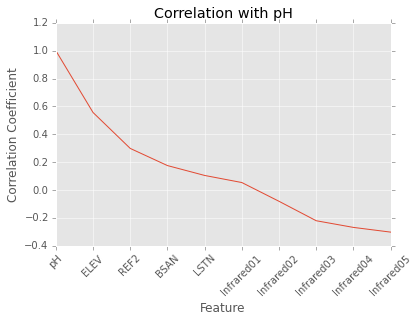

In [52]:
xlabels = data.columns
ax=data.corrwith(data['pH']).sort(inplace = False, ascending = False).plot()
ax.set_xticklabels(xlabels, rotation=45)
ax.set_title("Correlation with pH")
ax.set_xlabel("Feature")
ax.set_ylabel("Correlation Coefficient")

##Plot each of the features in turn
##Make some observations that might be pertinent to the choice of features necessary for the task at hand
####Hint : is there is an obvious case of colinearity amongst the prospective input features

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ecaa3d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10f03af50>], dtype=object)

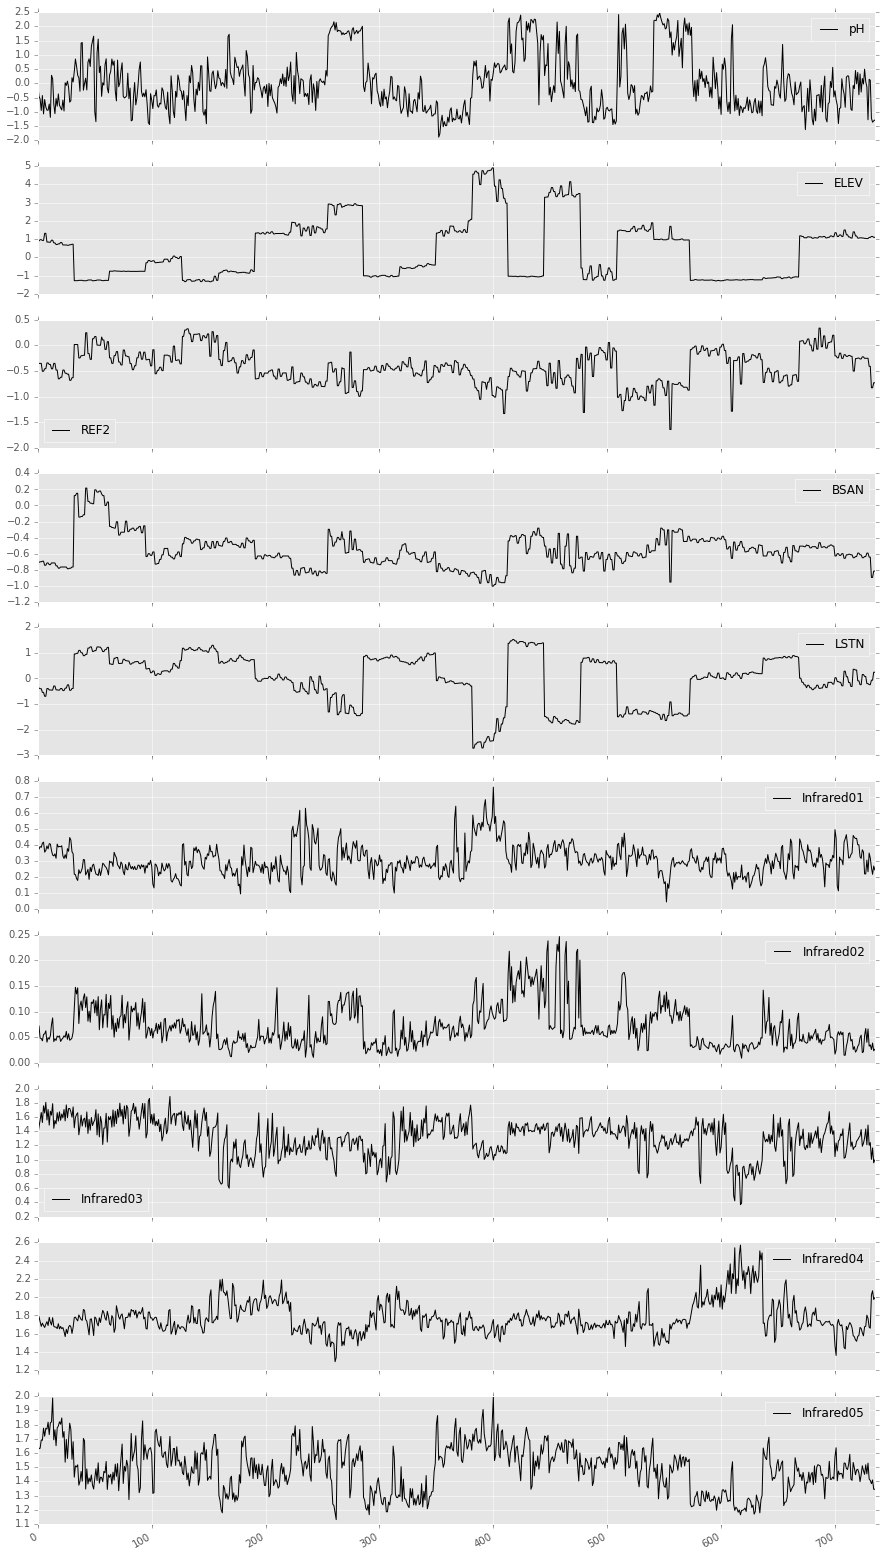

In [53]:
data.plot(subplots=True, figsize=(15,30))
#for i, a in enumerate(ax):
#    a.set_ylabel(data.columns[i])
#    a.set_xlabel("Index")
#    a.set_title("Plot of {:s}".format(data.columns[i]))

##General Observations 

There is an obvious case of colinearity. The ELEV and LSTN channels look the opposite of each other. Night time surface temperature and surface elevation intuitively should be negatively correlated with each other (-0.88 see below), i.e. the higher up the surface of the land is, the lower you would expect the temperature to be at night.

Its difficult to interpret what these channels provide in terms of information.
    
Having both channels ELEV and LSTN seems superfluous. 

In [54]:
data.corrwith(data["ELEV"])

pH            0.176186
ELEV          1.000000
REF2         -0.496091
BSAN         -0.463918
LSTN         -0.880093
Infrared01    0.480666
Infrared02    0.232696
Infrared03   -0.062068
Infrared04   -0.410551
Infrared05    0.458919
dtype: float64

##Let's look at the scatter plots for the 3 top features

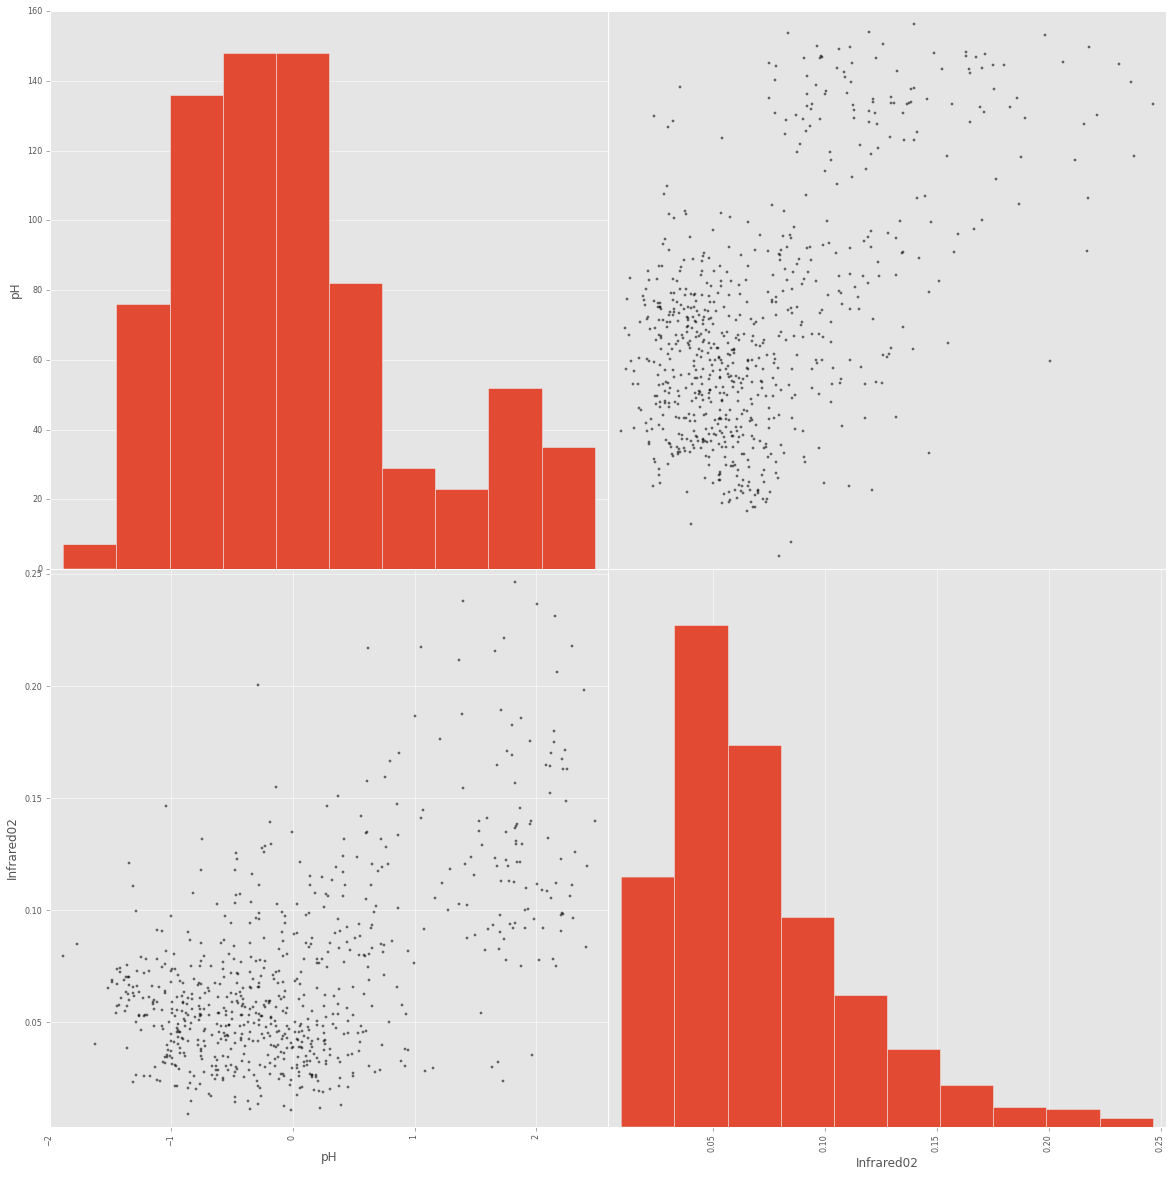

In [55]:
ax = pd.scatter_matrix(data[['pH', 'Infrared02']], figsize=(20, 20), color='k')

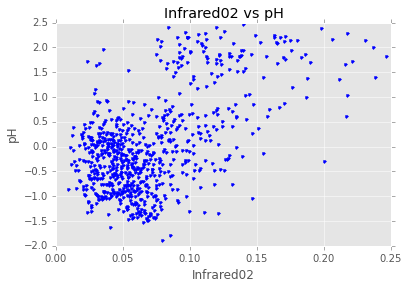

In [56]:
plt.plot(data["Infrared02"], data["pH"],'b.')
plt.title("Infrared02 vs pH")
plt.xlabel("Infrared02")
plt.ylabel("pH")

In [57]:
logph = np.log10(data['pH'].values)
loginfrared2 = np.log10(data['Infrared02'].values)

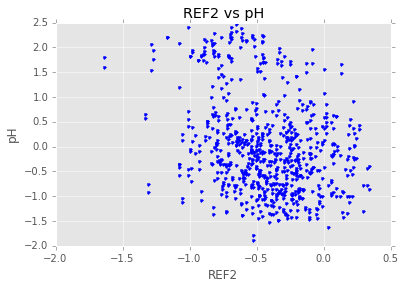

In [58]:
plt.plot(data["REF2"], data["pH"], 'b.')
plt.title("REF2 vs pH")
plt.xlabel("REF2")
plt.ylabel("pH")

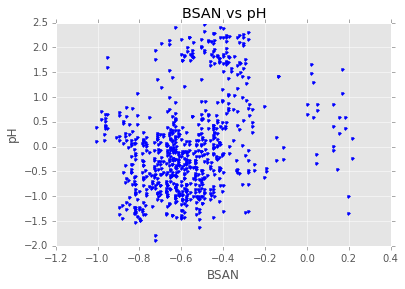

In [59]:
plt.plot(data["BSAN"], data["pH"],'b.')
plt.title("BSAN vs pH")
plt.xlabel("BSAN")
plt.ylabel("pH")

##The scatter plots for the other features:

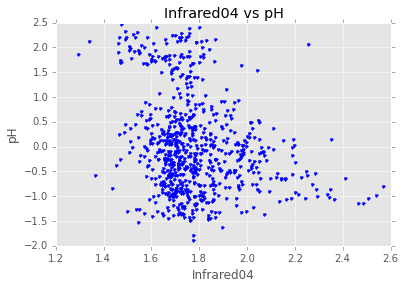

In [60]:
plt.plot(data["Infrared04"], data["pH"], 'b.')
plt.title("Infrared04 vs pH")
plt.xlabel("Infrared04")
plt.ylabel("pH")

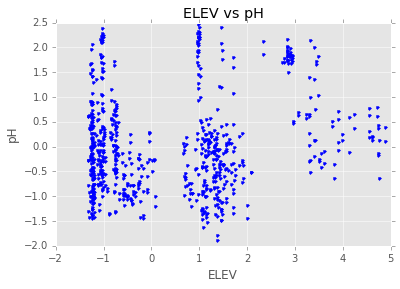

In [61]:
plt.plot(data["ELEV"], data["pH"],'b.')
plt.title("ELEV vs pH")
plt.xlabel("ELEV")
plt.ylabel("pH")

##Note the stratified type appearance in ELEV
##If a test sample came from a specific elevation we might consider subsetting the data based upon elevation

##Using your choice of features partition the dataset into a training set and a test set
###Be able to justify your choice of features
###Train a number of non-linear regression models of different degrees using the training set
###Test them on the test set and record the MSE on the test set for each model

In [62]:
#use the train_test_split functionality
X_train, X_test, y_train, y_test = \
train_test_split(data[["LSTN", "Infrared02","BSAN","REF2"]], \
                        data['pH'], test_size=0.2, random_state=42)

In [63]:
#Create and outer loop to increment the degree of the polynomial for fitting
#Record the model with the minimum Mean Squared Error

mse_min = 1e99

for degree in xrange(1, 10):
    clf = make_pipeline(PolynomialFeatures(degree, interaction_only=False), \
                        LinearRegression(fit_intercept=True))
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    mse = mean_squared_error(y_hat, y_test)
    print "Degree of Model = {:d}, MSE = {:5.2f}".format(degree, mse)
    if mse < mse_min:
        mse_min = mse
        best_clf = clf

Degree of Model = 1, MSE =  0.46
Degree of Model = 2, MSE =  0.42
Degree of Model = 3, MSE =  0.38
Degree of Model = 4, MSE =  0.42
Degree of Model = 5, MSE =  0.76
Degree of Model = 6, MSE = 17.06
Degree of Model = 7, MSE = 5361.26
Degree of Model = 8, MSE = 2410829.42
Degree of Model = 9, MSE = 192192937917.25


In [67]:
print best_clf

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, normalize=False))])


In [70]:
print len(X_test)

148


In [73]:
bc = best_clf.predict(X_test)
yy = np.ones(len(X_test))
thigh = bc + (yy * np.sqrt(low_mse))
tlow = bc - (yy * np.sqrt(low_mse))
x_plot = np.arange(0,148)

###Let's plot the actual and predicted side-by-side (remembering this is on un-seen test data)

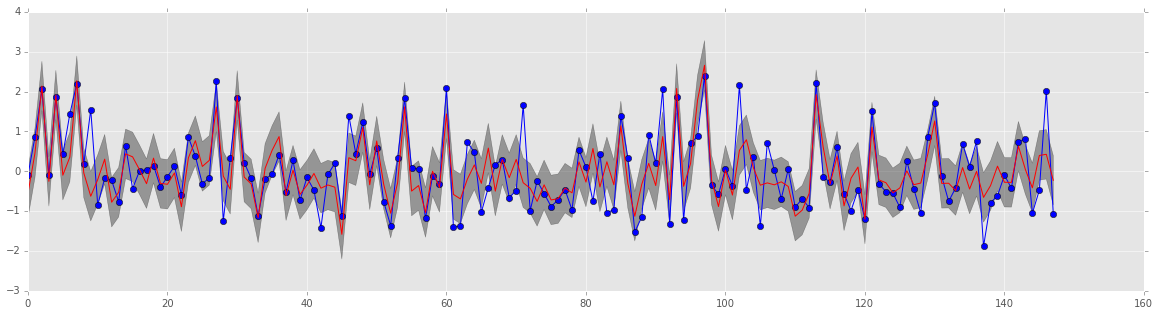

In [74]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(x_plot, y_test, color = 'blue', marker='o')
ax.plot(x_plot, best_clf.predict(X_test), color="red")
ax.fill_between(x_plot, thigh, tlow, color='k', alpha=.35)

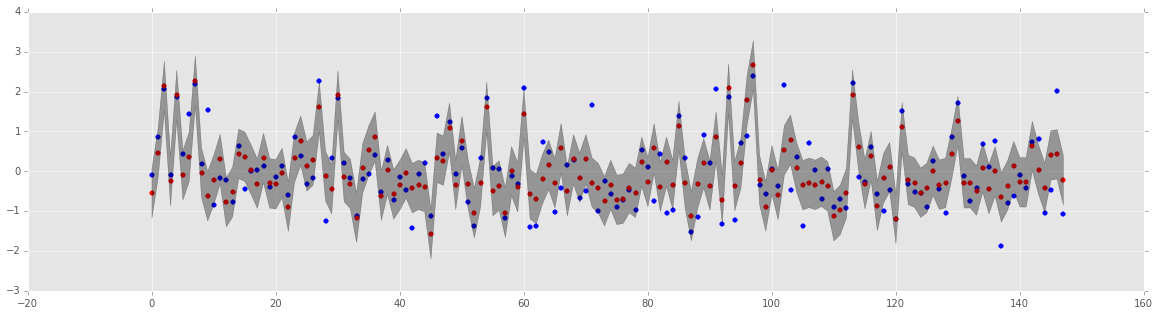

In [217]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.scatter(x_plot, y_test, color = 'blue', marker='o')
ax.scatter(x_plot, best_clf.predict(X_test), color="red", marker='o')
ax.fill_between(x_plot, thigh, tlow, color='k', alpha=.35)

##What is the correlation between the predicted pH on the test data and the actual test data pH?

In [218]:
resultsd = {'actual' : y_test, 'predicted' : best_clf.predict(X_test)}
results = pd.DataFrame(resultsd)
results.corr()

,actual,predicted
actual,1.000000,0.763437
predicted,0.763437,1.000000
